In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from gc import collect as collect_garbage
from psutil import virtual_memory
from os import scandir

In [41]:
%matplotlib widget

In [42]:
# Load in the data
df = pd.read_csv("01-unfiltered-rr-intervals/unfiltered-rr-intervals_1.csv")

In [43]:
# STEP 1: Flag any intervals of length less than 0.25 seconds (as this is physiologically unrealistic according to Alan), drop them, and then recalculate the RR intervals.
# This is equivalent to "folding in" each small interval into the next.
filt = df["interval"] >= 0.25

new_df = pd.DataFrame.copy(df.loc[filt], deep=True)
new_df.reset_index(inplace=True, drop=True)

new_df["interval"] = new_df["time"].diff()

del df
collect_garbage()

df = pd.DataFrame.copy(new_df, deep=True)
del new_df
collect_garbage()

virtual_memory()

svmem(total=12655771648, available=1283158016, percent=89.9, used=11372613632, free=1283158016)

In [44]:
# Confirm that intervals are of length at least 0.25
print( df["interval"].min() )

0.25000619888305664


In [45]:
# STEP 2: Remove any intervals of length greater than 10 seconds. This is an arbitrary threshold because it is not trivial to tell whether a long interval is due to 
# missing data (be that truly missing data or a segment corresponding to a trough in the raw ECG), or if it is due to a segment of beats left undetected by XQRS, so there's
# room for improvement at this step
# Also, note that this filter drops the NA value in the beginning, which is totally fine.

# In previous tests, the median was off center. We can try a lower threshold and see if that helps us here.

filt = df["interval"] <= 5
df = df.loc[filt]

In [46]:
# Verify that this worked
print( df["interval"].max() )

4.8574724197387695


In [23]:
# Before heading into step 3, we'll explore the distribution, multiples of the median, etc.
med = np.median(df["interval"])

filt = (df["interval"] > med) & (df["interval"] < 2*med)
argmin = np.round(df["interval"],4).loc[filt].value_counts().idxmin() 
# Okay, this works for *this* data, but it's not very robust; a small change in the number of decimal
# places can results in a large change to the R1 upper bound



In [24]:
print(med)
print(argmin)

0.3579742908477783
0.6338


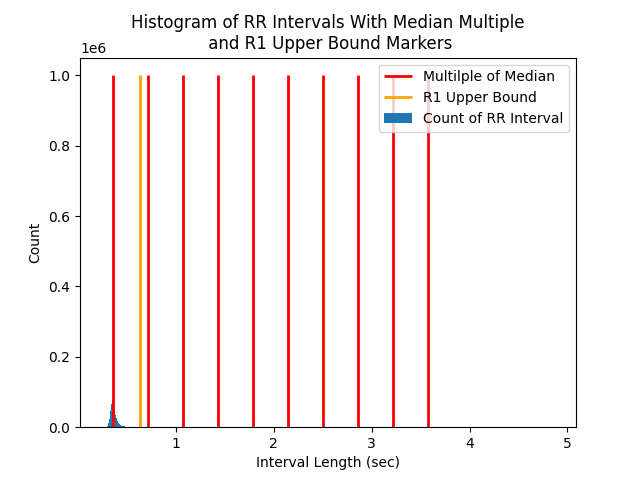

In [25]:
fig = plt.figure()
plt.hist(df["interval"], bins=2000, density=True, )
plt.vlines( [i*med for i in range(1,11)], 0, 10**6, color="red", linewidth=2 )
plt.vlines( argmin, 0, 10**6, color = "orange", linewidth=2 )
plt.legend(["Multilple of Median", "R1 Upper Bound", "Count of RR Interval"], loc="upper right")
plt.xlabel("Interval Length (sec)")
plt.ylabel("Count")
plt.title("Histogram of RR Intervals With Median Multiple\n and R1 Upper Bound Markers")
plt.show()


In [49]:
sns.distplot(df["interval"], hist=True, kde=True, bins = 2000,
hist_kws={"edgecolor": "black"},
kde_kws={"linewidth": 4})

C:\Users\aidan\AppData\Local\Temp/ipykernel_6488/851697979.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df["interval"], hist=True, kde=True, bins = 2000,


<AxesSubplot:xlabel='interval', ylabel='Density'>

In [50]:
virtual_memory()
# Okay, the above approach wasn't very successful, so I'm gonna try out the Gaussian mixture thing, maybe I'll get lucky
# Code from https://stats.stackexchange.com/questions/499130/fitting-mixture-model-of-gaussians-and-uniform-distributions-to-real-data

svmem(total=12655771648, available=1902723072, percent=85.0, used=10753048576, free=1902723072)

In [26]:
from sklearn.mixture import GaussianMixture

In [29]:
from scipy.stats import norm

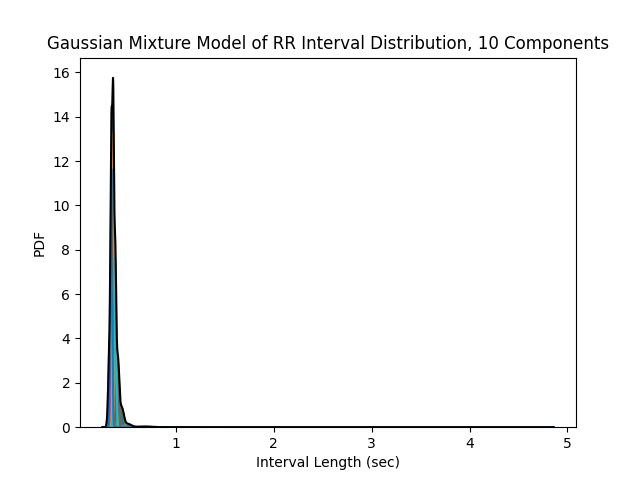

In [35]:
data = np.array(df["interval"])
comp = 10

gmm = GaussianMixture(n_components = comp).fit(data.reshape(-1, 1))

plt.figure()
plt.hist(data, bins=2000, density=True)
f_axis = data.copy().ravel()
f_axis.sort()
a = []
for weight, mean, covar in zip(gmm.weights_, gmm.means_, gmm.covariances_):
    a.append(weight*norm.pdf(f_axis, mean, np.sqrt(covar)).ravel())
    plt.plot(f_axis, a[-1])
plt.plot(f_axis, np.array(a).sum(axis =0), 'k-')
plt.xlabel('Interval Length (sec)')
plt.ylabel('PDF')
plt.title("Gaussian Mixture Model of RR Interval Distribution, " + str(comp) + " Components")
plt.show()